In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20_e import MapDatasetNuisanceE
from  my_fit_20 import Fit
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation import sys_dataset



## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : Gq88Cd7b 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

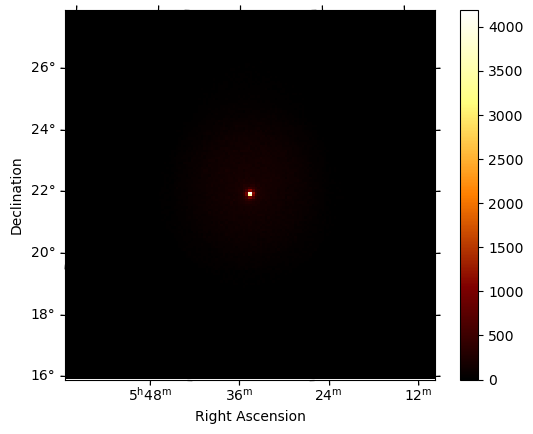

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
factors = np.array([-0.1])
sigma  =0.1
rnd = False
sys = sys_dataset(dataset_asimov, factors[0], rnd)
dataset_input = sys.create_dataset()


In [5]:
datasets = []
datasets_N = []

for i, factor in enumerate(factors):
    print(i, factor)
    sys = sys_dataset(dataset_asimov, factor, rnd)
    dataset = sys.create_dataset()
    datasets.append(dataset)

    dataset_N = sys.create_dataset_N(sigma)
    datasets_N.append(dataset_N)
    

0 -0.1


In [6]:
%%time
for i, factor in enumerate(factors):
    print(i, factor)
    fit = Fit(store_trace=False)
    result = fit.run([datasets[i]])


0 -0.1
CPU times: user 4.11 s, sys: 53 ms, total: 4.16 s
Wall time: 4.17 s


In [7]:
%%time
for i, factor in enumerate(factors):
    fit_N = Fit(store_trace=False)
    result_N = fit_N.run([datasets_N[i]])
    print(i, factor, datasets_N[i].N_parameters.value)


0 -0.1 [-0.04645584]
CPU times: user 50.1 s, sys: 4.58 s, total: 54.7 s
Wall time: 54.8 s


In [21]:
from  my_dataset_core_20 import Datasets as Datasets_N

dd = Datasets_N([datasets_N[0]])
dd.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
object,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.3004e+00,,6.154e-02,nan,nan,False,False,
spectral,amplitude,9.5418e-13,cm-2 s-1 TeV-1,8.935e-14,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,8.3630e+01,deg,3.792e-03,nan,nan,False,False,
spatial,lat_0,2.2019e+01,deg,4.950e-03,-9.000e+01,9.000e+01,False,False,
spatial,sigma,2.3540e-02,deg,2.004e-02,0.000e+00,nan,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,
spectral,norm,9.5338e-01,,2.246e-02,nan,nan,False,True,


## Correlation

In [11]:
from  my_fit_20_e import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    parameters = Parameters.from_stack([datasets_compute.models.parameters, 
                                        datasets_compute.N_parameters])
    parameters = parameters.free_parameters
    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

[[0.02246103]]


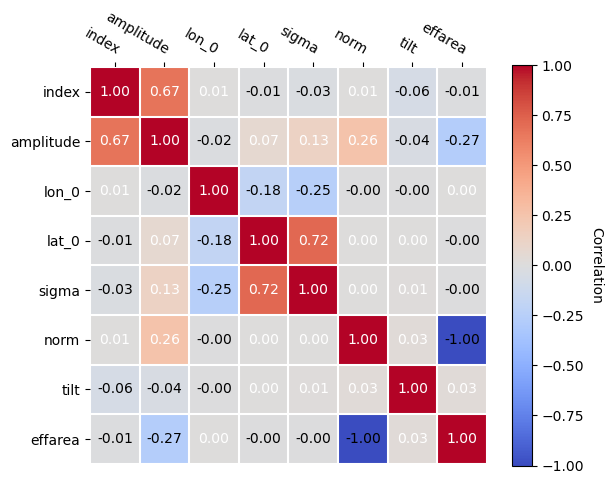

In [12]:
covariance  = covariance_(fit_N, datasets_N[0])
covariance.plot_correlation()


eff_area_error = np.sqrt(covariance.get_subcovariance([datasets_N[0].N_parameters[0]]))
print(eff_area_error)
fig = plt.gcf()
fig.savefig("plots/3_corr_matrix.pdf")